### Getting the camera working

Here are some steps needed. First you need to enable the camera. In a terminal type `sudo raspi-config` and then use the arrow keys to select interface options and then enable the camera. A reboot is required.

Next we need to install the picamera Python modulg. In a terminal type the command

`sudo apt-get install python3-picamera`

Because the red led on the camera creates light inside the spectrometer, we can turn it off by adding this line in `/boot/config.txt` and rebooting

`disable_camera_led=1`

That's it.

In [1]:
import numpy as np
import io
import matplotlib.pyplot as plt
import matplotlib.image as img
import ipywidgets as widgets

from picamera import PiCamera
from PIL import Image
from time import sleep, strftime
from IPython.display import clear_output

### Some helper routines

In [2]:
def take_picture(shutter):
    print("Initialising camera")
    camera = PiCamera()
    stream = io.BytesIO()
    try:
        print("Allowing camera to warmup")
        #camera.resolution = (2592, 1944)
        camera.resolution = (1296, 972)        
        camera.framerate= 5
        camera.rotation = 270
        camera.iso = 800
        camera.shutter_speed = shutter
        #camera.zoom = (0.50, 0.00, 0.08, 0.40)
        camera.awb_mode = 'off'
        camera.awb_gains = (1, 1)
        sleep(3)
        print("Capturing image")
        camera.capture(stream, format='jpeg')
        stream.seek(0)
        raw = Image.open(stream)
    finally:
        camera.close()
    return raw

In [3]:
def process_image(pixels):
  
    # Averaging along y
    pixels = np.average(pixels, axis=0)
    processed = Image.fromarray(np.uint8([pixels])) # The extra [] is to get back to image dimensions
    width, height = processed.size
    processed = processed.resize((width,255))
    
    return processed

In [4]:
def autocrop(img,xmin,xmax):
    
    pixels = np.asarray(img)
    
    # Get avergae value across each row in the image
    line = np.average(pixels[xmin:xmax,:,:], axis=(1,2))
    
    # Find all rows where the average value is above the threshhold
    thresh = 0.8*line.max()
    print('Row values: Max={:.1f}, Min={:.1f}, Treshhold={:.1f}'.format(line.max(),line.min(),thresh))    
    use = np.where(line > thresh)
    
    # Store the results in variables
    top = use[0][0]
    bottom = use[0][-1]
    left = xmin
    right = xmax
    print('Cropping: ',top, bottom, left, right)
    
    # Return just the cropped part of the image
    return pixels[top:bottom,left:right,:]

In [5]:
def get_spectrum(processed):
    spectrum = np.asarray(processed)
    spectrum = np.average(spectrum[0], axis=1)
    spectrum = spectrum-(0.9*min(spectrum))  # Subtract baseline
    spectrum = spectrum*(200/max(spectrum))  # Normalize to 200
    
    return spectrum

In [6]:
def display_results(raw,cropped,processed,spectrum,fname,shutter):
    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams.update({'font.size': 16})

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    
    pixels = np.asarray(processed)
    maxcol = [pixels[:,:,0].max(),pixels[:,:,1].max(),pixels[:,:,2].max()]
    factor = int(255 / max(maxcol))
    print ('Brightness factor : ', factor)
    pixels = factor*pixels
    
    plt.subplot(2,1,2)
    plt.xlabel('Pixel')
    plt.yticks([])
    plt.title('ORCSGirls Lego Spectrometer - Exposure: {}'.format(shutter))    
    plt.imshow(pixels, origin='lower')
    plt.plot(spectrum, color='yellow')
    
    plt.subplot(2,2,1)
    plt.title('Raw image') 
    plt.imshow(raw, origin='lower')
    
    plt.subplot(2,2,2)
    plt.title('Cropped image') 
    plt.imshow(cropped, origin='lower')

    plt.savefig(fname+'_processed.jpg')
    print("Plot saved to "+fname+"_processed.jpg")
    plt.show()

### Main control program

Initialising camera
Allowing camera to warmup
Capturing image
Row values: Max=30.6, Min=0.5, Treshhold=24.5
Cropping:  236 512 5 800
Brightness factor :  1
Plot saved to Spectra/Spectrum-20211010-154016_processed.jpg


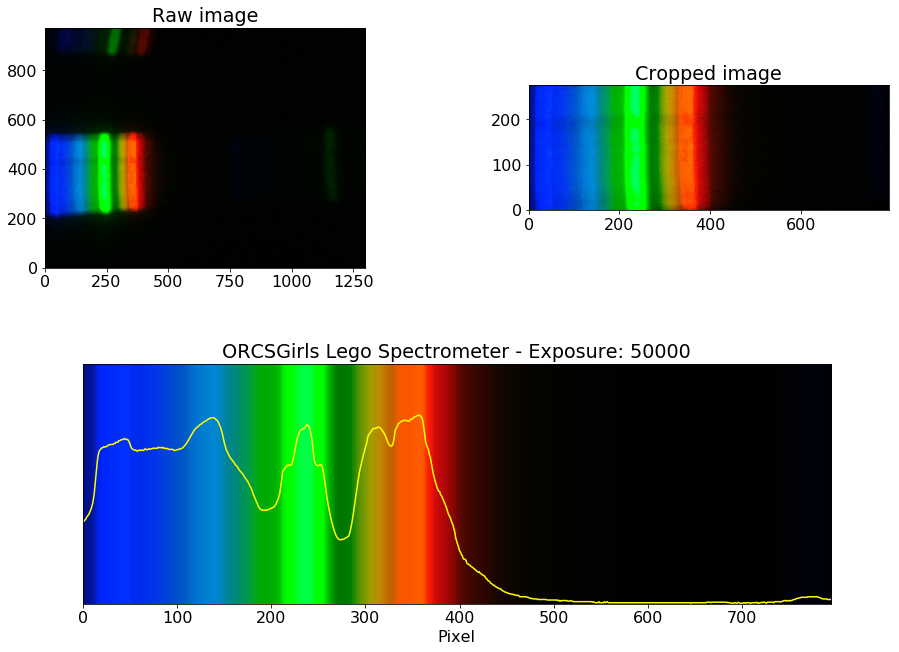

In [7]:
shutter = 50000      # Max exposure time (in usec - 6,000,000 max - 6sec)
xmin = 5             # Left most image pixel to use
xmax = 800           # Right most image pixel to use

timestr = strftime("%Y%m%d-%H%M%S")
fname = 'Spectra/Spectrum-'+timestr

raw = take_picture(shutter)
raw.save(fname+"_raw.jpg")

cropped = autocrop(raw, xmin, xmax)
processed = process_image(cropped)
spectrum = get_spectrum(processed)

display_results(raw,cropped, processed, spectrum, fname, shutter)

## Playground

Here we test some routines for image processing and automatic region of interest.

In [8]:
file = open("Spectra/Spectrum-20211008-123748_processed.jpg", "rb")
image = file.read()
image_widget = widgets.Image(
    value=image,
    format='jpg',
)

In [9]:
image_widget

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\…

In [10]:
file = open("Spectra/Spectrum-20211007-145110_processed.jpg", "rb")
image2 = file.read()

In [11]:
image_widget.value=image

In [12]:
title = widgets.Text(
    value='',
    placeholder='',
    description='Sample:',
    disabled=False
)

exposure = widgets.Text(
    value='1',
    placeholder='',
    description='Exposure:',
    disabled=False
)

button = widgets.Button(
    description='Measure',
    disabled=False,
    button_style='success'
)

control=widgets.HBox([title, exposure, button])
layout=widgets.VBox([control,image_widget])
layout

Brightness factor :  1
Plot saved to Spectra/Spectrum-20211010-154016_processed.jpg


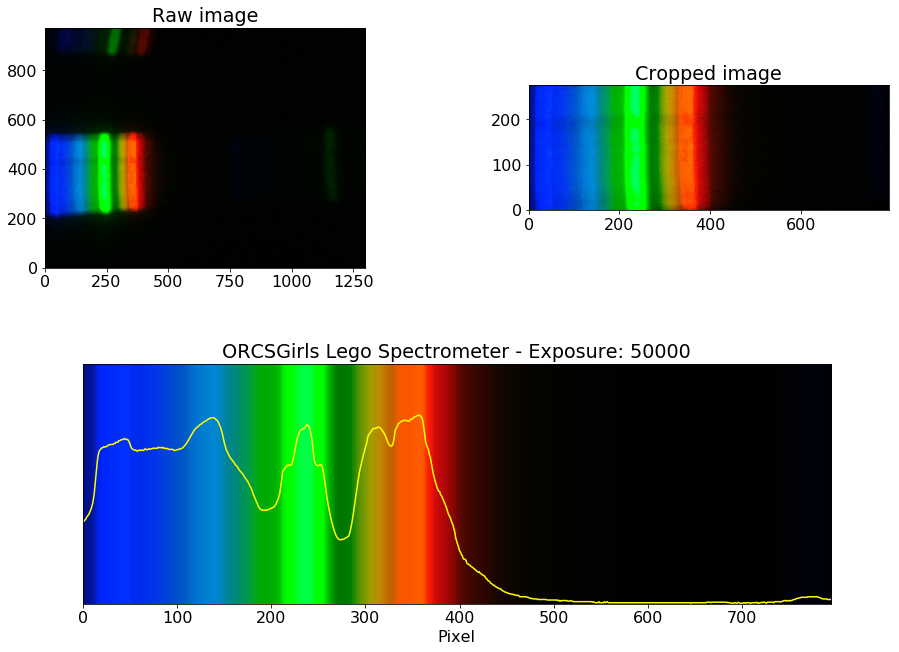

In [13]:
display_results(raw,cropped, processed, spectrum, fname, shutter)